---
author: Martiño Ríos García
date: 2024-05-17
title: 4 | Choosing the learning paradigm
keep-ipynb: True
---

The objective of this book is to illustrate with a practical example how to decide which learning paradigm is better for each application. To illustrate the process, some information about chemical reactions will be extracted from paragraphs of text.

## First steps

Choosing the learning paradigm should begin trying some models with a general pre-training. For this practical case, the first model to test is the very recent Llama-3 8B model with a zero and one-shot prompts.

We will start by installing and importing all the packages needed.

In [1]:
! pip install -qqq torch transformers datasets evaluate accelerate peft trl bitsandbytes langchain python-dotenv litellm numpy matplotlib --progress-bar off

In [2]:
import warnings
import os
warnings.filterwarnings('ignore')
os.environ["WANDB_SILENT"]="true"

In [3]:
import json 
import wandb
from dotenv import load_dotenv

import torch
from datasets import (
    load_dataset,
)
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
)
from peft import (
    LoraConfig,
)
from trl import (
    SFTTrainer,
    DataCollatorForCompletionOnlyLM,
)
from evaluate import load
import litellm
from litellm import completion
from litellm.caching import Cache
from statistics import mean
import numpy as np 
import matplotlib.pyplot as plt 

To continue we will allow for the caching of `LiteLLM` to accelerate the completions. Additionally, we will import all environment variables. 

::: {.column-margin}
Note that using the environment variables is the safest way of keeping personal API keys secret.
:::

In [4]:
litellm.cache = Cache()
load_dotenv(".env", override=True)

## First model and dataset

As starting model, we will try the Llama-3 8B model. We will call this model through the *Groq API*, which allows performing fast inference with several open-source models.

```{margin}
It is important to include the *HF_token* in the *.env* file. By the time this notebook was created, the model that we are going to fine-tune (Llama3-8B) is only available after request for access.
```

In [6]:
base_model = "groq/llama3-8b-8192"

The dataset used in this tutorial is the one used in Ai et al.'s [@Ai_2024] recent work, which contains data about chemical reactions. The dataset contains 100K reaction procedure—ORD JSON pairs. 

::: {.column-margin}
**ORD** stands for *Open Reaction Database* schema, a comprehensive data structure specially designed to describe all the elements involved in chemical reactions.
:::
<!-- 
---
reference-location: margin
citation-location: margin
--- -->

In [7]:
test_ds_path = "test.json"
test_dataset = load_dataset("json", data_files=test_ds_path, split="train")
test_dataset = test_dataset.shuffle(seed=42)
test_dataset

Dataset({
    features: ['instruction', 'output'],
    num_rows: 100
})

This dataset is very big. Therefore, we will only take 100 samples from the test set used in the article mentioned above for our test set.

## Prompt and Inference

We define a simple prompt template. The prompt contains a simple *system* part (named as *PREFIX*) where the role and task of the model is defined as well as the example used only for the 1-shot prompt. 
Additionally, the prompt has a *user* prompt where the reaction instruction will be provided.

In [8]:
PREFIX = """You are a helpful scientific assistant. Your task is to extract information about organic reactions. {shot}"""
SUFFIX = """\n\n{sample}\n\n"""
SHOT = """
One example is provided to you to show how to perform the task:

### Procedure:\nA suspension of 8 g of the product of Example 7 and 0.4 g of DABCO in 90 ml of xylenes were heated under N2 at 130\u00b0-135\u00b0 C. while 1.8 ml of phosgene was added portionwise at a rate to maintain a reflux temperature of about 130\u00b0-135\u00b0 C. The mixture was refluxed an additional two hours, cooled under N2 to room temperature, filtered, and the filtrate was concentrated in vacuo to yield 6.9 g of the subject compound as a crude oil.\n\n
### ORD JSON:\n{\"inputs\": {\"m1_m2_m4\": {\"components\": [{\"identifiers\": [{\"type\": \"NAME\", \"value\": \"product\"}], \"amount\": {\"mass\": {\"value\": 8.0, \"units\": \"GRAM\"}}, \"reaction_role\": \"REACTANT\"}, {\"identifiers\": [{\"type\": \"NAME\", \"value\": \"DABCO\"}], \"amount\": {\"mass\": {\"value\": 0.4, \"units\": \"GRAM\"}}, \"reaction_role\": \"REACTANT\"}, {\"identifiers\": [{\"type\": \"NAME\", \"value\": \"xylenes\"}], \"amount\": {\"volume\": {\"value\": 90.0, \"units\": \"MILLILITER\"}}, \"reaction_role\": \"SOLVENT\"}]}, \"m3\": {\"components\": [{\"identifiers\": [{\"type\": \"NAME\", \"value\": \"phosgene\"}], \"amount\": {\"volume\": {\"value\": 1.8, \"units\": \"MILLILITER\"}}, \"reaction_role\": \"REACTANT\"}]}}, \"conditions\": {\"temperature\": {\"control\": {\"type\": \"AMBIENT\"}}, \"conditions_are_dynamic\": true}, \"workups\": [{\"type\": \"ADDITION\", \"details\": \"was added portionwise at a rate\"}, {\"type\": \"TEMPERATURE\", \"details\": \"to maintain a reflux temperature of about 130\\u00b0-135\\u00b0 C\"}, {\"type\": \"TEMPERATURE\", \"details\": \"The mixture was refluxed an additional two hours\", \"duration\": {\"value\": 2.0, \"units\": \"HOUR\"}}, {\"type\": \"FILTRATION\", \"details\": \"filtered\"}, {\"type\": \"CONCENTRATION\", \"details\": \"the filtrate was concentrated in vacuo\"}], \"outcomes\": [{\"products\": [{\"identifiers\": [{\"type\": \"NAME\", \"value\": \"subject compound\"}], \"measurements\": [{\"type\": \"AMOUNT\", \"details\": \"MASS\", \"amount\": {\"mass\": {\"value\": 6.9, \"units\": \"GRAM\"}}}], \"reaction_role\": \"PRODUCT\"}]}]}
\n
"""

To continue, we loop all over the dataset two times, one for each type of prompt (zero and one-shot). For each dataset sample, we format the prompt to include the procedure-output schema pairs using the template defined in the previous cell. In addition, we also predict using the model and store those predictions for future evaluation.

In [9]:
# Generate text
results_llama = {}
for i in range(2):
    predictions = []
    references = []

    for t in test_dataset:
        instruction = t["instruction"]
        output = t["output"]
        if i == 0:
            shot = ""
        else:
            shot = SHOT
        system = PREFIX.format(shot=shot)
        user = SUFFIX.format(sample=instruction)
        prompt = [
            {"role": "system", "content": system},
            {"role": "user", "content": user},
        ]
        pred = (
            completion(
                model=base_model,
                messages=prompt,
                caching=True,
                temperature=0,
            )
            .choices[0]
            .message.content
        )

        references.append(output)
        predictions.append(pred)

    results_llama[f"{i}-shot"] = {
        "predictions": predictions,
        "references": references,
    }

After generating the predictions, it's essential to evaluate them. We will initially use BERT Score for a simple evaluation, as it provides precision, recall, and F$_1$-scores based on similarity measures. However, for a complex schema like the one we are predicting, a more robust evaluation method should be utilized. (REF EVALUATION CHAPTER)

In [11]:
bertscore = load("bertscore")

for i in range(2):
    predictions = results_llama[f"{i}-shot"]["predictions"]
    references = results_llama[f"{i}-shot"]["references"]

    results_ = bertscore.compute(
        predictions=predictions,
        references=references,
        model_type="distilbert-base-uncased",
    )

    results_llama[f"{i}-shot"].update(
        {
            "precision": mean(results_["precision"]),
            "recall": mean(results_["recall"]),
            "f1_scores": mean(results_["f1"]),
        }
    )

In [12]:
# Remember to safe the results for future evaluation!
with open('Llama_results.json', 'w') as f:
   json.dump(results_llama, f, indent=4)

## Another model, closed-source this time

We are not going to study the results with the previous model for now, we will suppose they are bad, so we will try to use another model to improve them.

The second model we will use is the newer OpenAI model, the **GPT-4o** model. This allows us to compare open- and closed-source models.

The procedure and code are exactly the same as for the previous case; the only difference is to define a different model.

::: {.column-margin}
*OpenAI* models are also supported by the *LiteLLM* package.
:::

In [5]:
base_model = "gpt-4o"

And we do the completions using both prompts for all the test samples.

In [8]:
# Generate text
results_openai = {}
for i in range(2):
    predictions = []
    references = []

    for t in test_dataset:
        instruction = t["instruction"]
        output = t["output"]
        if i == 0:
            shot = ""
        else:
            shot = SHOT
        system = PREFIX.format(shot=shot)
        user = SUFFIX.format(sample=instruction)
        prompt = [
            {"role": "system", "content": system},
            {"role": "user", "content": user},
        ]
        pred = (
            completion(
                model=base_model,
                messages=prompt,
                caching=True,
                temperature=0,
            )
            .choices[0]
            .message.content
        )

        if "```json" in pred:
            pred = pred.replace("```json\n", "")
            pred = pred.replace("```", "")

        references.append(output)
        predictions.append(pred)

    results_openai[f"{i}-shot"] = {
        "predictions": predictions,
        "references": references,
    }

Finally, we evaluate again using *BERT-score*. 

In [ ]:
for i in range(2):
    predictions = results_openai[f'{i}-shot']['predictions']
    references = results_openai[f'{i}-shot']['references']

    results_ = bertscore.compute(predictions=predictions, references=references, model_type="distilbert-base-uncased")

    results_openai[f'{i}-shot'].update({
        'precision': mean(results_['precision']),
        'recall': mean(results_['recall']),
        'f1_scores': mean(results_['f1']),
    })

In [11]:
# Remember to safe the results for future evaluation!
with open('OpenAI_results.json', 'w') as f:
   json.dump(results_openai, f, indent=4)

## Fine-tuning

As the final step, we will fine-tune the Llama-3 8B using data similar to the one we used above.

We will use packages built by HuggingFace to do the fine-tuning.

First, we define the base model we will use and the path of the dataset. 

In [3]:
# Model
base_model = "meta-llama/Meta-Llama-3-8B-Instruct"

# Dataset
dataset_path = "LLM_organic_synthesis/workplace_data/datasets/USPTO-n100k-t2048_exp1/train.json"

```{margin}
This will make it easy to track training progress using [Weights and Biases](https://wandb.ai/), allowing quick access to the loss curve and other important training parameters.
```

In [ ]:
wandb.login()

The next step is to load the dataset for the fine-tuning. For that, as for the testing from previous models, we will use the dataset used by Ai et al., but for this case, we will use their **train** dataset. Since this is a quick demonstration, we will only take 5000 samples.

In [ ]:
dataset = load_dataset("json", data_files=dataset_path, split="train")
dataset = dataset.shuffle(seed=42).select(range(5000)) # Only use 5000 samples for quick demo
dataset = dataset.train_test_split(test_size=0.1, seed=42)
dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'output'],
        num_rows: 900
    })
    test: Dataset({
        features: ['instruction', 'output'],
        num_rows: 100
    })
})

In [ ]:
dataset['train'][0]

{'instruction': 'Below is a description of an organic reaction. Extract information from it to an ORD JSON record.\n\n### Procedure:\nTo a solution of 5-bromo-2-methyl-1H-indole (3.0 g, 14.35 mmol) in dry tetrahydrofuran (20 ml) was added sodium hydride (900 mg, 22.5 mmol) with ice-cooling. After stifling for about 30 min, a solution of t-BuLi (27.5 ml, 1.3 M solution in hexane) was added dropwise with stifling at −78° C. under an inert atmosphere of nitrogen. The reaction mixture was warmed slowly to −40° C. over 45 min and stirred at this temperature for another 30 min. The mixture was cooled again below −78° C., followed by the addition of 4,4,5,5-tetramethyl-2-(propan-2-yloxy)-1,3,2-dioxaborolane (5.3 g, 28.49 mmol) dropwise. After warming to room temperature, the mixture was quenched with NH4Cl solution (100 ml) and extracted with ethyl acetate (3×100 ml). The combined organic layers were dried over anhydrous sodium sulfate, filtered and concentrated under reduced pressure to give

Then we define the method to fine-tune and all the parameters. For this fine-tuning we will be using the popular QLoRA method.[REFERENCE TO QLORA]

In [ ]:
# QLoRA config

# Activate 4-bit precision base model loading
# Compute dtype for 4-bit base models
# Quantization type (fp4 or nf4)
# Activate nested quantization for 4-bit base models
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

# LoRA config
peft_config = LoraConfig(
    r=32, # The rank of the update matrices, expressed in int. Lower rank results in smaller update matrices with fewer trainable parameters.
    lora_alpha=64, # LoRA scaling factor. It changes how the adaptation layer's weights affect the base model's
    lora_dropout=0.1, # Dropout is a regularization technique where a proportion of neurons (or parameters) are randomly “dropped out” or turned off during training to prevent overfitting.
    bias="none", # Specifies if the bias parameters should be trained. Can be 'none', 'all' or 'lora_only'.
    task_type="CAUSAL_LM", # Task to perform, Causal LM: Causal language modeling.
)

Before training, we define the tokenizer and the model for fine-tuning, set the training arguments, and initialize the trainer.

In [ ]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Model config
# Where the model is placed,set device_map="auto" loads a model onto multiple GPUs..
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    device_map="auto",
)

In [ ]:
training_arguments = TrainingArguments(
    learning_rate=3e-6,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    optim="paged_adamw_32bit",
    num_train_epochs=10,
    fp16=False,
    bf16=True, #bf16 to True with an A100
    logging_steps=1,
    evaluation_strategy="steps",
    eval_steps=0.05,
    max_grad_norm=0.3,
    warmup_steps=10,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="cosine",
    output_dir="./results/",
    save_strategy='no', # Only safe the final model, not the checkpoints
)

In [ ]:
response_template = " ### Answer:"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

In [ ]:
def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example['instruction'])):
        text = f"### Question: {example['instruction'][i]}\n ### Answer: {example['output'][i]}"
        output_texts.append(text)
    return output_texts

In [ ]:
trainer = SFTTrainer(
    model=model,
    max_seq_length=None,
    args=training_arguments,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    peft_config=peft_config,
    tokenizer=tokenizer,
    packing=False,
    formatting_func=formatting_prompts_func,
    data_collator=collator,
)

And finally when everything is ready we train the model.

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
28,0.999600,0.636476
56,0.836100,0.604613
84,0.827700,0.574966
112,0.753000,0.549391
140,0.683700,0.527555
168,0.700800,0.507865
196,0.713200,0.489182
224,0.599200,0.471585
252,0.643600,0.460574
280,0.603600,0.455087


TrainOutput(global_step=560, training_loss=0.5340924625418015, metrics={'train_runtime': 2403.4626, 'train_samples_per_second': 3.745, 'train_steps_per_second': 0.233, 'total_flos': 3.342546165492941e+17, 'train_loss': 0.5340924625418015, 'epoch': 9.955555555555556})

We can consult the loss curves from WandB to see if the training performs well and if there is no overfitting or other strange behavior.

::: {#fig-elephants layout-ncol=2}

![Training-loss curve](test_loss.png){#fig-eloss}

![Evaluation-loss curve](eval_loss.png){#fig-tloss}

Loss curves from the process that were reported to *WandB*.
:::

The easiest way to evaluate the fine-tuned model and perform inference is to use the trained model directly. To do that, we have to define a pipeline for text generation, do the inference using that pipeline, and evaluate in a similar way as for the previous models. To evaluate the fine-tuned model and do inference, the easiest way is to use the trained model directly. To do that we have to define a *pipeline* for text-generation and then do the inference using that *pipeline* and evaluate in a similar way as for the previous models.

In [9]:
sft_pipe = pipeline(
    "text-generation",
    temperature=0.01,
    model=trainer.model,
    tokenizer=tokenizer,
)

In [ ]:
# Generate text for the 0-shot
results_sft = {}
for i in range(2):
    print(f"Working in the {i}-shot prompts")
    references = []
    predictions_sft = []
    prompts = []
    count = 0
    for t in test_dataset:
        count += 1
        print(f"Working in the prompt {count}")
        instruction = t['instruction']
        output = t['output']
        if i == 0:
            shot = ''
        else:
            shot = SHOT
        system = PREFIX.format(shot=shot)
        user = SUFFIX.format(sample=instruction)
        prompt = system + user
        references.append(output)
        
        with torch.cuda.amp.autocast():
            pred = sft_pipe(prompt)
        predictions_sft.append(pred[0]['generated_text'].replace(prompt, ''))
    
    results_sft [f"{i}-shot"] = {
        "predictions": predictions_sft,
        "references": references,
    }

In [ ]:
for i in range(2):
    predictions_sft = results_sft[f'{i}-shot']["predictions"]
    references = results_sft[f'{i}-shot']["references"]

    results = bertscore.compute(predictions=predictions_sft, references=references, model_type="distilbert-base-uncased")

    results_sft[f"{i}-shot"].update({
        "precision": mean(results["precision"]),
        "recall": mean(results["recall"]),
        "f1_scores": mean(results["f1"]),
    })

In [12]:
with open('sft_results.json', 'w') as f:
   json.dump(results_sft, f, indent=4)

## Visualization of the results

To visualize all the results we can simply plot them in two bars plots.

::: {#fig-elephants layout-ncol=2}

![0-shot](bars0.png){#fig-0shot}

![1-shot](bars1.png){#fig-1shot}

Results for the three models.
:::

The results for the three models are quite good, and there are no significant differences between them. This is partly due to the evaluation method used; however, employing a more robust evaluation will lead to more noticeable differences. For this reason, we recommend reviewing the Evaluations section and following the guidelines outlined there.

In [4]:
models = ['llama', 'sft', 'openai']
metrics = ['precision', 'recall', 'f1_scores']

In [5]:
# Organize the results for easy plotting

results = {}

results['llama_results'] = results_llama
results['openai_results'] = results_openai
results['sft_results'] = results_sft

metrics_0_shot = []
metrics_1_shot = []
for model in models:
    tmp_0 = []
    tmp_1 = []
    for metric in metrics:
        tmp_0.append(results[model + '_results']['0-shot'][metric])
        tmp_1.append(results[model + '_results']['1-shot'][metric])
    metrics_0_shot.append(tmp_0)
    metrics_1_shot.append(tmp_1)

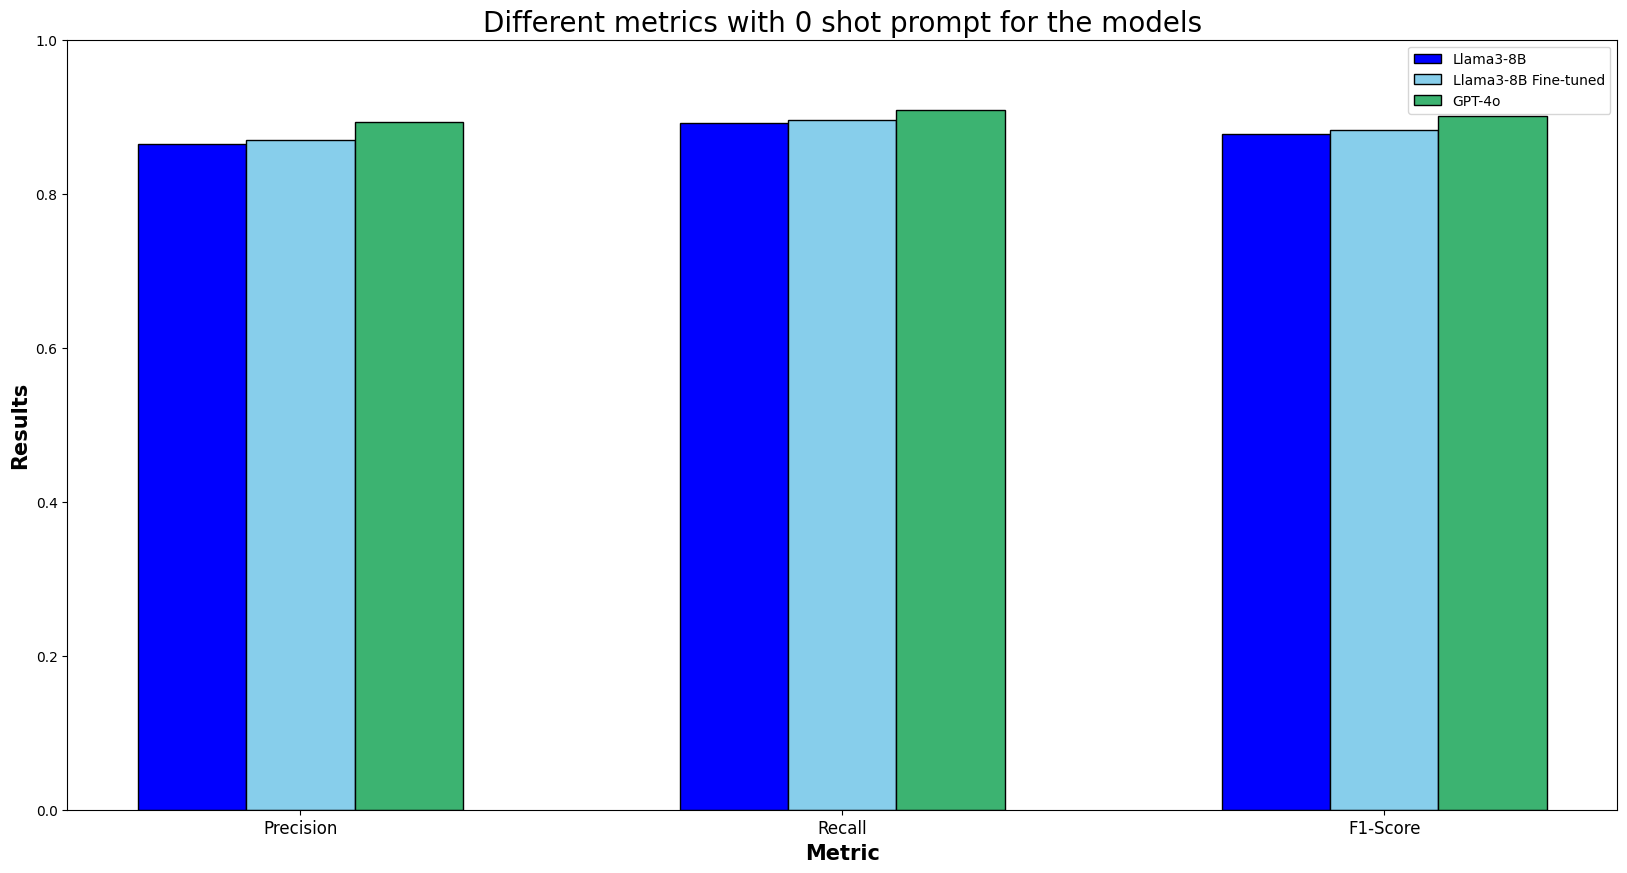

In [6]:
# set width of bar
barWidth = 0.2
fig = plt.subplots(figsize=(20, 10))

plt_models = ["Llama3-8B", "Llama3-8B Fine-tuned", "GPT-4o"]
plt_metrics = ["Precision", "Recall", "F1-Score"]
plt_data = {}
for index, model in enumerate(plt_models):
    plt_data[model] = metrics_0_shot[index]

# Set position of bar on X axis
br1 = np.arange(len(metrics_0_shot[0]))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(
    br1,
    metrics_0_shot[0],
    color="b",
    width=barWidth,
    edgecolor="black",
    label=plt_models[0],
)
plt.bar(
    br2,
    metrics_0_shot[1],
    color="skyblue",
    width=barWidth,
    edgecolor="black",
    label=plt_models[1],
)
plt.bar(
    br3,
    metrics_0_shot[2],
    color="mediumseagreen",
    width=barWidth,
    edgecolor="black",
    label=plt_models[2],
)

# Adding Xticks
plt.xlabel("Metric", fontweight="bold", fontsize=15)
plt.ylabel("Results", fontweight="bold", fontsize=15)
plt.xticks(
    [r + barWidth for r in range(len(metrics_0_shot[0]))], plt_metrics, fontsize=12
)
plt.ylim(0, 1)
plt.title("Different metrics with 0 shot prompt for the models", fontsize=20)

plt.legend()
plt.savefig("bars0.png")
plt.show()

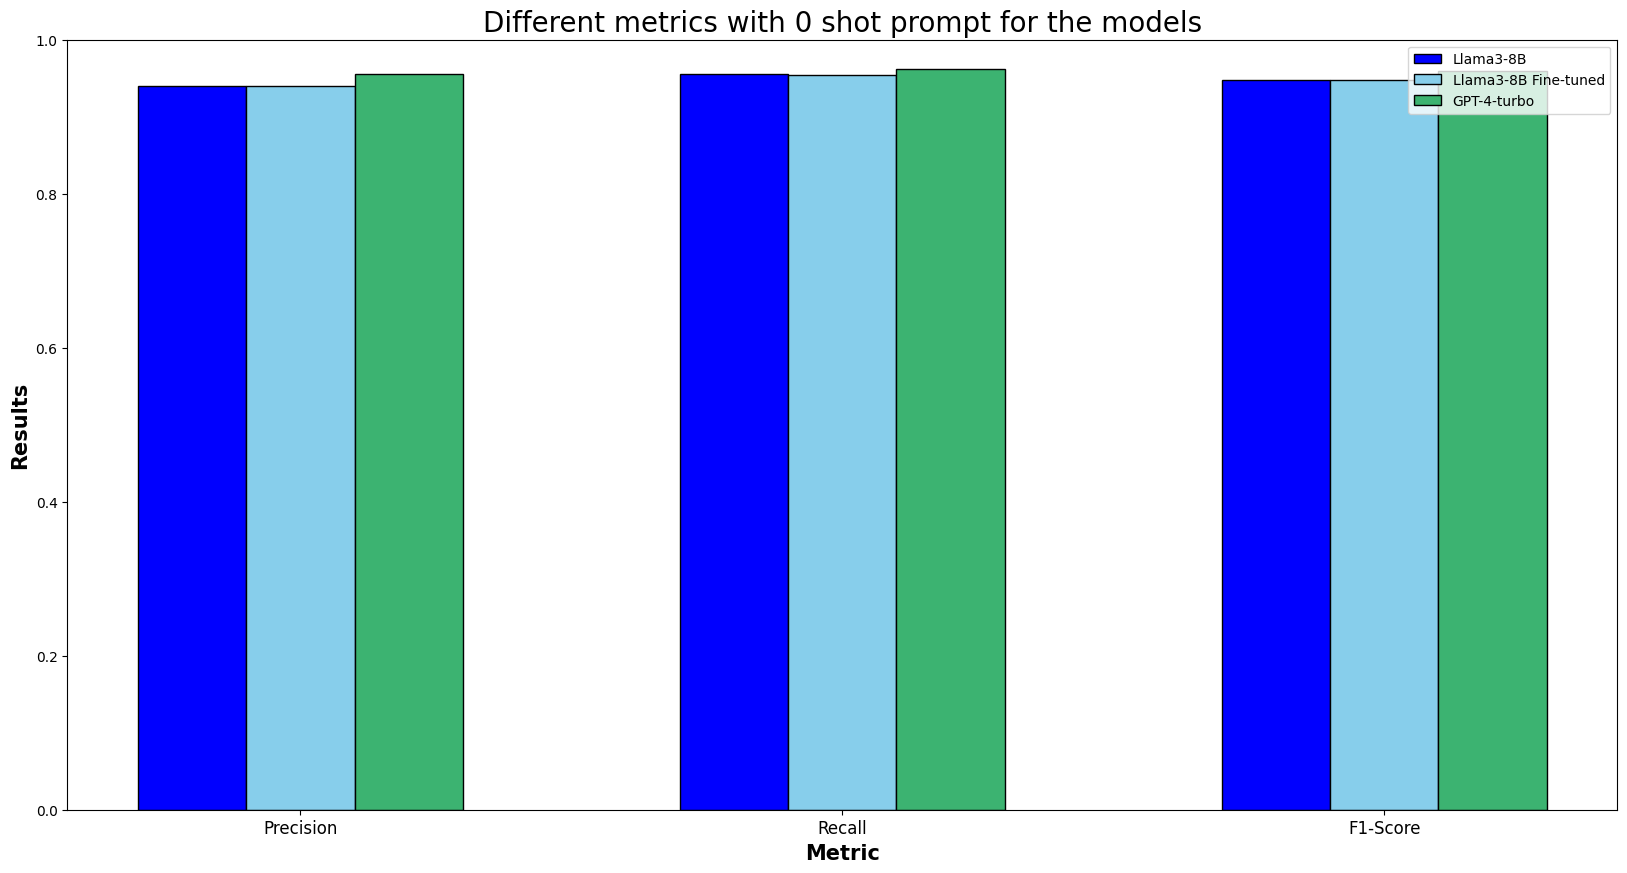

In [7]:
# set width of bar
barWidth = 0.2
fig = plt.subplots(figsize=(20, 10))

plt_models = ["Llama3-8B", "Llama3-8B Fine-tuned", "GPT-4-turbo"]
plt_metrics = ["Precision", "Recall", "F1-Score"]
plt_data = {}
for index, model in enumerate(plt_models):
    plt_data[model] = metrics_1_shot[index]

# Set position of bar on X axis
br1 = np.arange(len(metrics_1_shot[0]))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(
    br1,
    metrics_1_shot[0],
    color="b",
    width=barWidth,
    edgecolor="black",
    label=plt_models[0],
)
plt.bar(
    br2,
    metrics_1_shot[1],
    color="skyblue",
    width=barWidth,
    edgecolor="black",
    label=plt_models[1],
)
plt.bar(
    br3,
    metrics_1_shot[2],
    color="mediumseagreen",
    width=barWidth,
    edgecolor="black",
    label=plt_models[2],
)

# Adding Xticks
plt.xlabel("Metric", fontweight="bold", fontsize=15)
plt.ylabel("Results", fontweight="bold", fontsize=15)
plt.xticks(
    [r + barWidth for r in range(len(metrics_1_shot[0]))], plt_metrics, fontsize=12
)
plt.ylim(0, 1)
plt.title("Different metrics with 1-shot prompt for the models", fontsize=20)

plt.legend()
plt.savefig("bars1.png")
plt.show()